<h1 style="color:blue; text-align:center;">Brain Tumor Detector</h1>

## Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
# For image transformations and dataset handling in PyTorch
from torchvision import transforms,datasets

# For efficient data loading and handling
from torch.utils.data import DataLoader,ConcatDataset,random_split

Importing necessary modules for Deep Learning with PyTorch, including neural network layers, optimization algorithms, EfficientNet from `efficientnet_pytorch`, and learning rate scheduling (`ReduceLROnPlateau`).


In [41]:
# !pip install efficientnet_pytorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import ReduceLROnPlateau

# For model evaluation
from sklearn.metrics import classification_report

##### Importing Custom Visualization Functions

To keep the notebook concise, we import custom visualization functions from `visualization_utils.py`

In [5]:
from visualization_utils import show_images, count_images_per_class, print_dataset_info, plot_image_counts, plot_training_validation, plot_confusion_matrix

## Loading the Dataset

We download the Brain Tumor Classification MRI dataset from Kaggle. The dataset is then unzipped to a specified directory for further use.

In [6]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 93% 81.0M/86.8M [00:01<00:00, 67.6MB/s]
100% 86.8M/86.8M [00:01<00:00, 67.4MB/s]


In [7]:
# Unzipping the data

import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-classification-mri.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
# Define the paths to data
train_path = '/content/Training'
test_path = '/content/Testing'

## Data Preparation

- **Transformations**:
  - `Resize`: Resizes the images to 150x150 pixels.
  - `ToTensor`: Converts the images to PyTorch tensors.
  - `Normalize`: Normalizes the images with mean and standard deviation values to ensure pixel values are within a consistent range, which helps in stabilizing and speeding up the training process.

In [9]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
# Create datasets using ImageFolder
dataset1 = datasets.ImageFolder(root=train_path, transform=transform)
dataset2 = datasets.ImageFolder(root=test_path, transform=transform)

In [11]:
# Combining the datasets
dataset = ConcatDataset([dataset1, dataset2])

The combined dataset is split into Training, Validation and Test sets. The split is performed in an 80-10-10 ratio.

In [12]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = test_size = (total_size - train_size) // 2
val_size += 1

# Split dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Creating Data Loaders for the training, validation, and test sets. The training data loader is shuffled to ensure that the model generalizes better.



In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Visualizing Data

In [14]:
# Print the class names
class_names = train_dataset.dataset.datasets[0].classes
print(f'The classes are: {class_names}')

The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


##### Displaying Sample Images

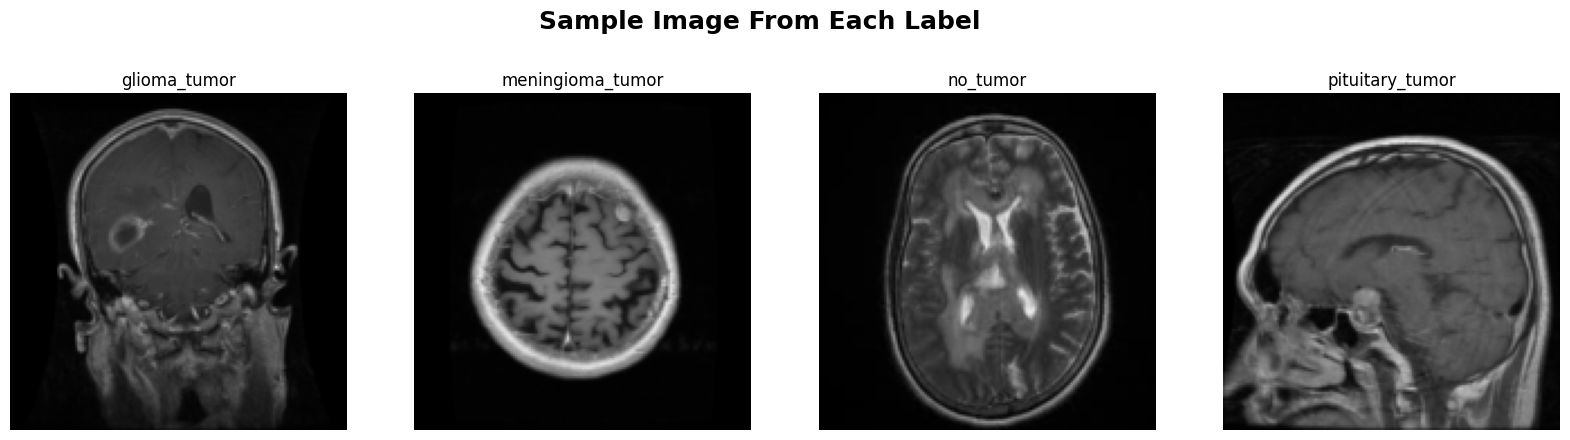

In [15]:
images = []
titles = []

for class_name in class_names:
    for img, label in train_dataset:
        if train_dataset.dataset.datasets[0].classes[label] == class_name:
            images.append(img)
            titles.append(class_name)
            break

show_images(images, titles, 'Sample Image From Each Label')

##### Counting Images per Class

In [16]:
# Count images in training, validation, and test datasets
train_count = count_images_per_class(train_dataset, class_names)
val_count = count_images_per_class(val_dataset, class_names)
test_count = count_images_per_class(test_dataset, class_names)

# Print the results
print_dataset_info("Training", train_count)
print_dataset_info("Validation", val_count)
print_dataset_info("Test", test_count)

Training Data:
Class 'glioma_tumor': 741 images
Class 'meningioma_tumor': 740 images
Class 'no_tumor': 405 images
Class 'pituitary_tumor': 725 images
	Total images in training data: 2611
Validation Data:
Class 'glioma_tumor': 96 images
Class 'meningioma_tumor': 90 images
Class 'no_tumor': 53 images
Class 'pituitary_tumor': 88 images
	Total images in validation data: 327
Test Data:
Class 'glioma_tumor': 89 images
Class 'meningioma_tumor': 107 images
Class 'no_tumor': 42 images
Class 'pituitary_tumor': 88 images
	Total images in test data: 326


In [17]:
warnings.filterwarnings('ignore',category = DeprecationWarning)

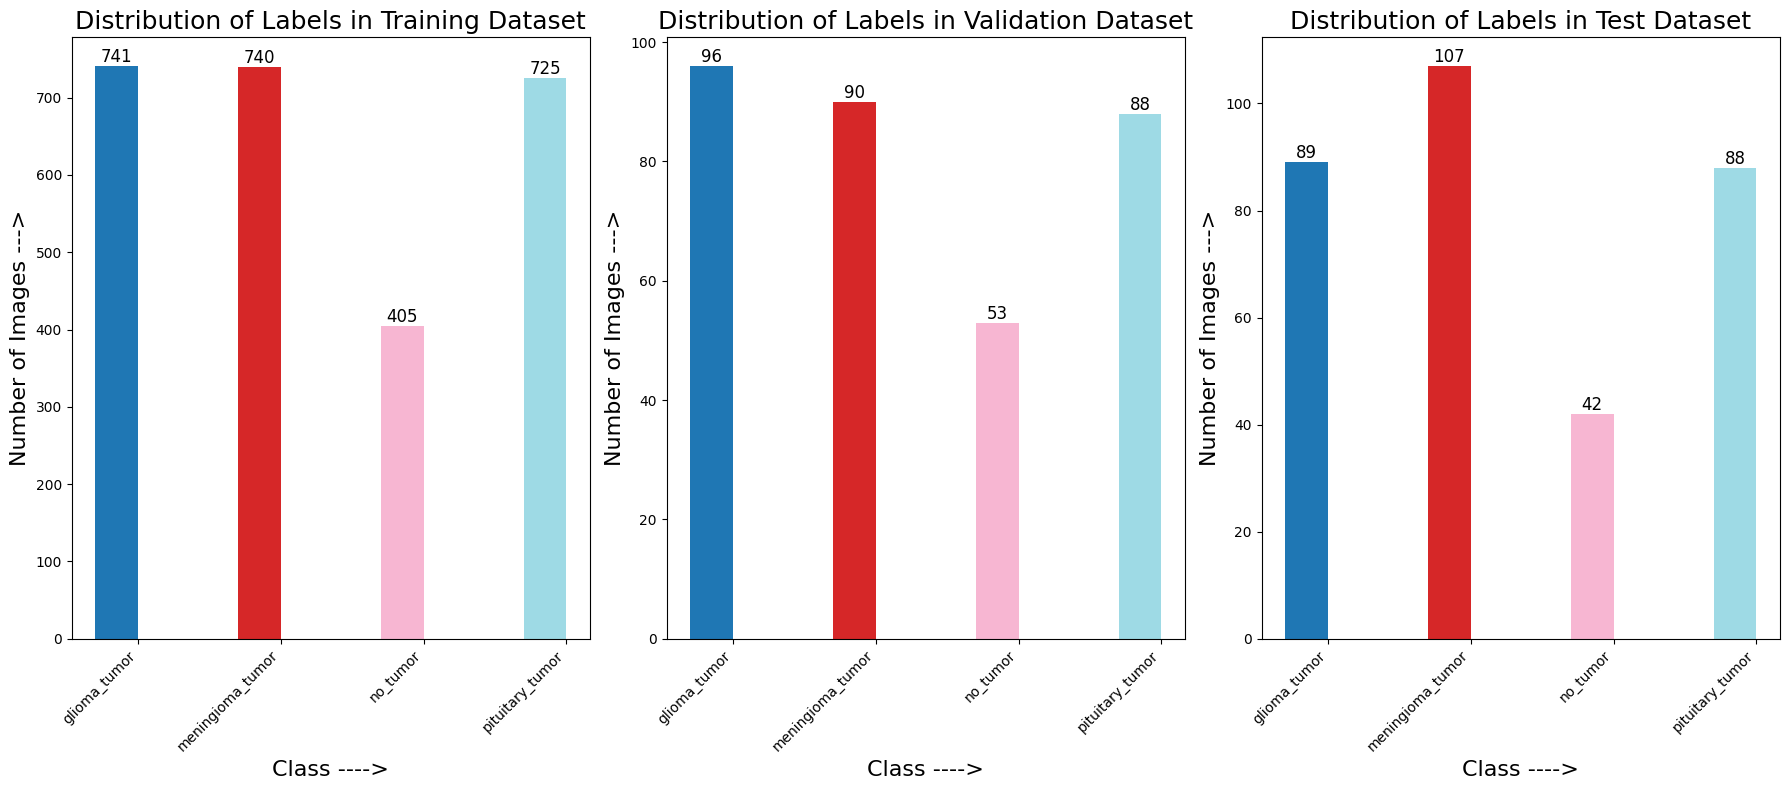

In [18]:
# Plotting Bar Chart for Image counts
num_classes = len(class_names)
color_palette = plt.cm.get_cmap('tab20', num_classes)

# Plot for each dataset using the color palette
plt.figure(figsize=(18, 8))

plt.subplot(1, 3, 1)
plot_image_counts(train_count, "Training", color_palette)

plt.subplot(1, 3, 2)
plot_image_counts(val_count, "Validation", color_palette)

plt.subplot(1, 3, 3)
plot_image_counts(test_count, "Test", color_palette)

plt.tight_layout()
plt.show();

## Model Building

Defining a custom Convolutional Neural Network (CNN) model using PyTorch. The model is designed for Image classification tasks.

#### ***CNN Model Architecture :-***

##### Convolutional Layers
1. **Conv Layer 1**:
   - Channels: 3 → 12
   - BatchNorm, ReLU, MaxPool (75x75)
2. **Conv Layer 2**:
   - Channels: 12 → 20
   - ReLU
3. **Conv Layer 3**:
   - Channels: 20 → 32
   - BatchNorm, ReLU, MaxPool (37x37)

##### Fully Connected Layer
- **Flatten Layer**: Converts tensor to 2D.
- **Linear Layer**: Features: 32 * 37 * 37 → `num_classes`

##### Weight Initialization
- **Xavier Uniform Initialization**: Applied to fully connected layer weights.
- **Bias Initialization**: Sets bias to zero.

In [19]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Reduces spatial dimensions to 75x75

            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces spatial dimensions to 37x37
        )

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Flatten(),  # Flattens the tensor before passing to fully connected layer
            nn.Linear(in_features=32 * 37 * 37, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0)

*Implements Early Stopping to halt training when validation loss fails to improve. Saves the best model state based on validation loss.*

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # Negate because a lower val_loss is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'\nEarly Stopping with Best Loss')
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print('\nValidation Loss improved. Saving model...')
        torch.save(model.state_dict(), self.path)

In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
conv_model=ConvNet(num_classes=4).to(device)

In [23]:
from torchsummary import summary

summary(conv_model, (3, 150, 150))  # Specify input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
              ReLU-9           [-1, 32, 75, 75]               0
        MaxPool2d-10           [-1, 32, 37, 37]               0
          Flatten-11                [-1, 43808]               0
           Linear-12                    [-1, 4]         175,236
Total params: 183,632
Trainable params: 183,632
Non-trainable params: 0
-------------------------------

*Visual representation of the custom Convolutional Neural Network (CNN) model architecture used for the classification task.*

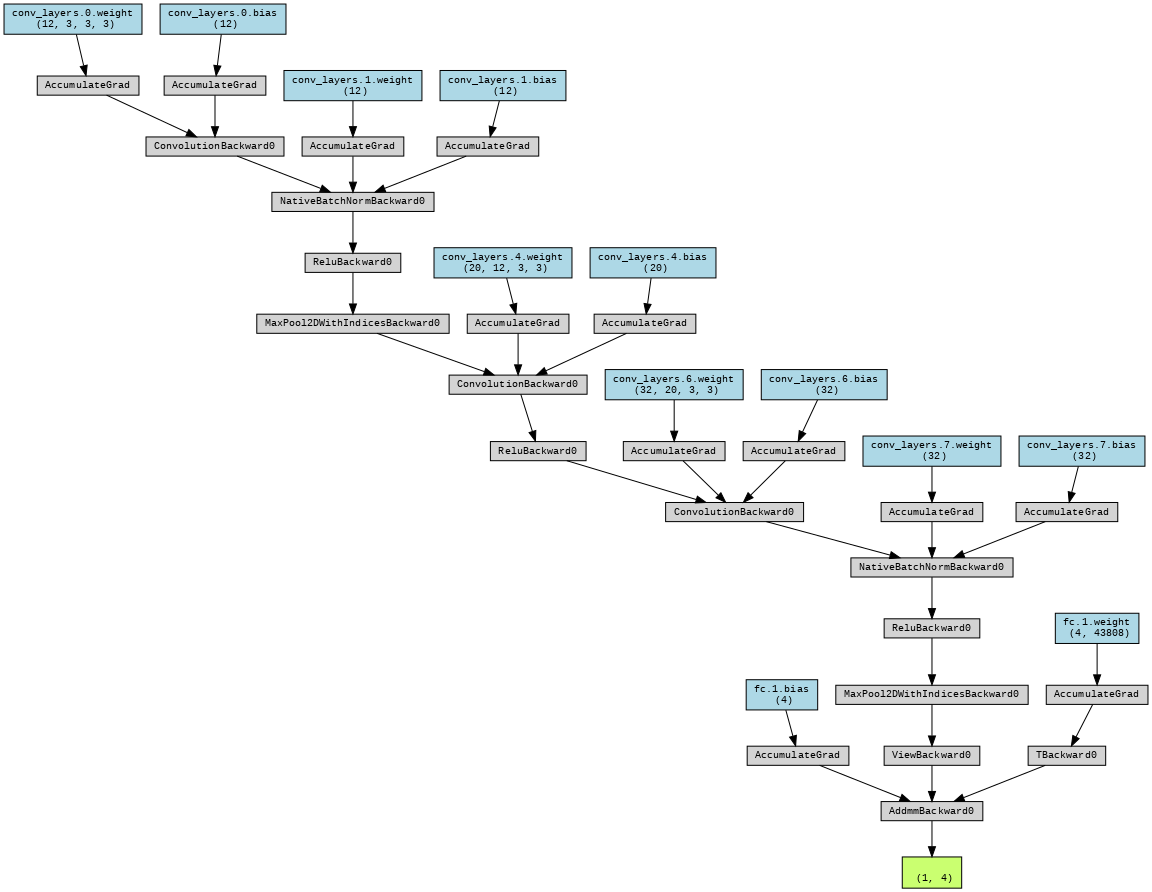

Define the CrossEntropyLoss criterion for multi-class classification and use the Adam optimizer to train the `conv_model`.


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.parameters(), lr=0.001)

In [25]:
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Define early stopping and model checkpointing
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0, path='checkpoint.pt')

Train the `conv_model` for 20 epochs using CrossEntropyLoss criterion and Adam optimizer with a learning rate of 0.001. Implement Early Stopping based on validation loss and save the Best model weights using a checkpoint mechanism.

In [26]:
num_epochs = 20
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

for epoch in range(num_epochs):
    conv_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = conv_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    train_acc_history.append(train_accuracy)
    train_loss_history.append(train_loss / len(train_loader.dataset))

    conv_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = conv_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_acc_history.append(val_accuracy)
        val_loss_history.append(val_loss / len(val_loader.dataset))

    # Update scheduler and check early stopping
    scheduler.step(val_loss)
    early_stopping(val_loss, conv_model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%')

# Load the best model weights
conv_model.load_state_dict(torch.load('checkpoint.pt'))


Validation Loss improved. Saving model...
Epoch 1/20, Train Loss: 3.1909, Train Accuracy: 57.64%, Val Loss: 1.2693, Val Accuracy: 73.70%

Validation Loss improved. Saving model...
Epoch 2/20, Train Loss: 0.7799, Train Accuracy: 77.14%, Val Loss: 1.2356, Val Accuracy: 77.98%

Validation Loss improved. Saving model...
Epoch 3/20, Train Loss: 0.5567, Train Accuracy: 83.95%, Val Loss: 0.7074, Val Accuracy: 79.82%

Validation Loss improved. Saving model...
Epoch 4/20, Train Loss: 0.2723, Train Accuracy: 90.43%, Val Loss: 0.5894, Val Accuracy: 85.63%
Epoch 5/20, Train Loss: 0.1255, Train Accuracy: 95.21%, Val Loss: 0.6466, Val Accuracy: 86.24%

Validation Loss improved. Saving model...
Epoch 6/20, Train Loss: 0.1884, Train Accuracy: 93.41%, Val Loss: 0.5840, Val Accuracy: 86.54%
Epoch 7/20, Train Loss: 0.0885, Train Accuracy: 96.32%, Val Loss: 0.8994, Val Accuracy: 83.49%
Epoch 8/20, Train Loss: 0.0769, Train Accuracy: 97.17%, Val Loss: 0.7538, Val Accuracy: 82.87%
Epoch 9/20, Train Loss: 0

<All keys matched successfully>

##### *Plotting Training and Validation Results*

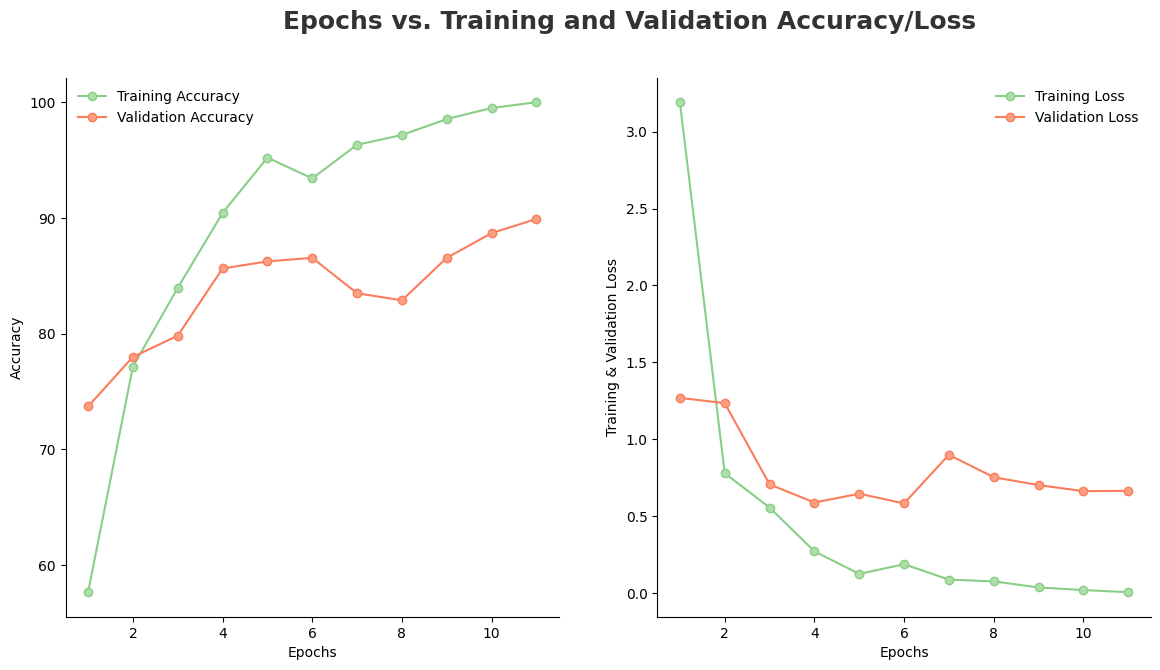

In [27]:
epochs = range(1, len(train_acc_history) + 1)
plot_training_validation(epochs, train_acc_history, val_acc_history, train_loss_history, val_loss_history)

##### **Custom CNN Model Evaluation**

In [28]:
# Testing the model
conv_model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = conv_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.4321, Test Accuracy: 88.96%


## **Transfer Learning**

*Transfer Learning leverages pretrained models like EfficientNetB0, originally trained on ImageNet, to accelerate model training on new datasets by utilizing learned features. By excluding the top layers, we customize the model for specific tasks, optimizing performance and reducing computational burden, making it ideal for tasks like Image Classification without starting from scratch.*

##### **EfficientNetB0Custom Model**

This model is based on EfficientNet-B0 pretrained on ImageNet, excluding the top layers. It is designed for transfer learning, enabling efficient training and high performance in image classification tasks. The model consists of:

- EfficientNet-B0 backbone for feature extraction.
- Adaptive average pooling to adapt to different input sizes.
- Dropout layer to prevent overfitting.
- Custom fully connected layer for classification.

The weights of the fully connected layer are initialized using Xavier uniform initialization. This approach allows for rapid development and deployment of robust Computer Vision models.

In [29]:
# Defining the EfficientNetB0Custom model
class EfficientNetB0Custom(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetB0Custom, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.effnet._fc.in_features, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.effnet.extract_features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0)

Initialize the model, define the CrossEntropyLoss as the loss function, and set up the Adam optimizer with a learning rate of 0.001.

In [30]:
# Initializing the model, loss function, and optimizer
model = EfficientNetB0Custom(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 237MB/s]

Loaded pretrained weights for efficientnet-b0


Summarizing the `EfficientNetB0Custom` Model Architecture

In [31]:
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 151, 151]               0
Conv2dStaticSamePadding-2           [-1, 32, 75, 75]             864
       BatchNorm2d-3           [-1, 32, 75, 75]              64
MemoryEfficientSwish-4           [-1, 32, 75, 75]               0
         ZeroPad2d-5           [-1, 32, 77, 77]               0
Conv2dStaticSamePadding-6           [-1, 32, 75, 75]             288
       BatchNorm2d-7           [-1, 32, 75, 75]              64
MemoryEfficientSwish-8           [-1, 32, 75, 75]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

*Define the learning rate scheduler (`scheduler`) to adjust optimizer parameters during training based on validation loss changes. Also, set up early stopping (`early_stopping`) to halt training if validation loss does not improve after a certain number of epochs.*


In [32]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

early_stopping = EarlyStopping(patience=5, verbose=True, delta=0, path='checkpoint.pt')

Implement a training loop with early stopping and model checkpointing to monitor training and validation metrics. The loop optimizes the `model` using a defined loss function (`criterion`) and updates parameters (`optimizer`) based on gradients.


In [33]:
# Training loop with early stopping and model checkpointing
num_epochs = 20
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    train_acc_history.append(train_accuracy)
    train_loss_history.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_acc_history.append(val_accuracy)
        val_loss_history.append(val_loss / len(val_loader.dataset))

    # Update scheduler and check early stopping
    scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%')

# Load the best model weights
model.load_state_dict(torch.load('checkpoint.pt'))


Validation Loss improved. Saving model...
Epoch 1/20, Train Loss: 0.4592, Train Accuracy: 83.34%, Val Loss: 0.9834, Val Accuracy: 75.54%

Validation Loss improved. Saving model...
Epoch 2/20, Train Loss: 0.1684, Train Accuracy: 94.26%, Val Loss: 0.7245, Val Accuracy: 80.43%
Epoch 3/20, Train Loss: 0.1212, Train Accuracy: 95.94%, Val Loss: 1.1222, Val Accuracy: 72.78%
Epoch 4/20, Train Loss: 0.0799, Train Accuracy: 97.05%, Val Loss: 1.0307, Val Accuracy: 74.92%

Validation Loss improved. Saving model...
Epoch 5/20, Train Loss: 0.0832, Train Accuracy: 97.05%, Val Loss: 0.4230, Val Accuracy: 88.07%
Epoch 6/20, Train Loss: 0.0687, Train Accuracy: 97.93%, Val Loss: 0.4965, Val Accuracy: 88.07%

Validation Loss improved. Saving model...
Epoch 7/20, Train Loss: 0.0429, Train Accuracy: 98.58%, Val Loss: 0.2733, Val Accuracy: 94.19%

Validation Loss improved. Saving model...
Epoch 8/20, Train Loss: 0.0473, Train Accuracy: 98.47%, Val Loss: 0.2635, Val Accuracy: 94.80%
Epoch 9/20, Train Loss: 0

<All keys matched successfully>

*Plotting training and validation accuracy/loss against epochs to visualize model performance trends over training epochs.*


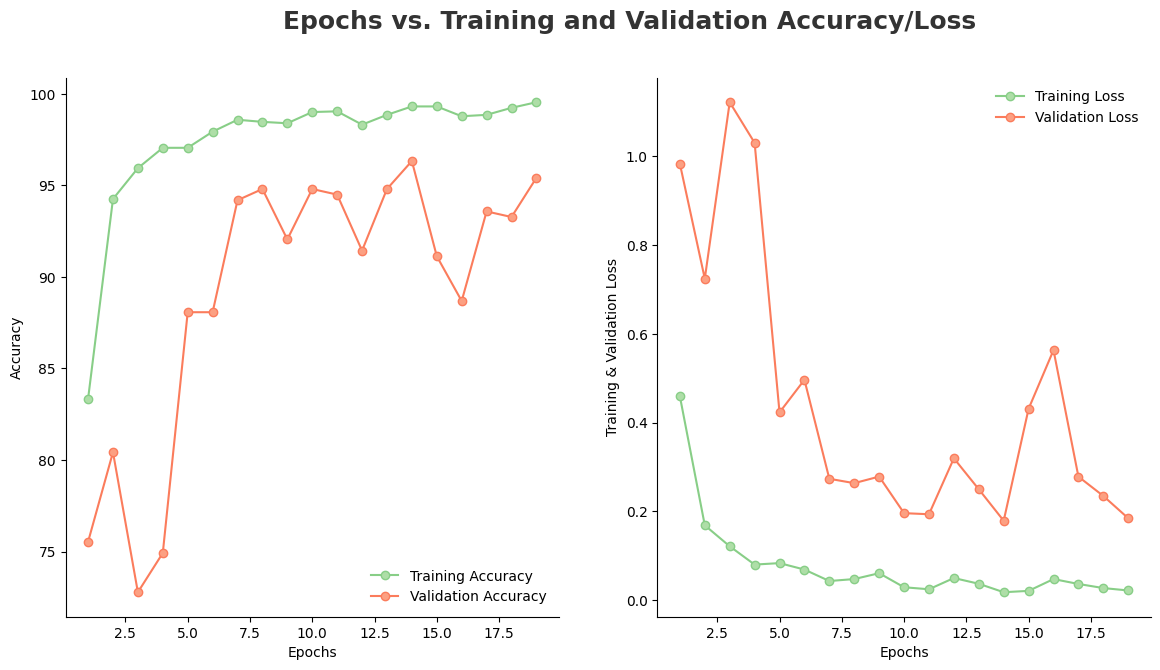

In [34]:
epochs = range(1, len(train_acc_history) + 1)
plot_training_validation(epochs, train_acc_history, val_acc_history, train_loss_history, val_loss_history)

## Model Evaluation

Evaluating the model on the test dataset (`test_loader`) to compute `test_loss` and accuracy (`test_acc`) in order to to assess the model's performance on unseen data.


In [35]:
# Testing the model
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.1739, Test Accuracy: 97.24%


### **Prediction**

*Displaying a sample image from the test dataset with its ground truth class label and predicting the class using the trained model.*

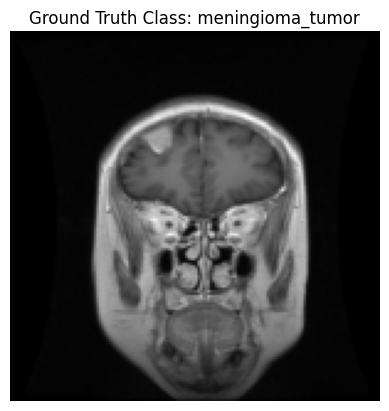

In [36]:
# Select an image from the test dataset (change index as needed)
index = 264
image, label = test_dataset[index]

# Normalize the image data
image = image.numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy and rearrange dimensions
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

# Display the normalized image
plt.imshow(image)
plt.axis('off')
plt.title(f"Ground Truth Class: {class_names[label]}")
plt.show();

In [37]:
image, label = test_dataset[index]

# Perform prediction
model.eval()
with torch.no_grad():
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image.to(device))  # Predict
    _, predicted = torch.max(output, 1)

# Display the predicted class
print(f"Predicted Class: {class_names[predicted.item()]}")

Predicted Class: meningioma_tumor


Define a function `make_predictions` that takes a PyTorch model and a test data loader as input. It evaluates the model on the test set, collects true and predicted labels, and returns them as `y_true` and `y_pred` arrays.

In [38]:
# Function to make predictions on the test set
def make_predictions(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

y_true, y_pred = make_predictions(model, test_loader)

Generating the Classification Report using `classification_report` from `sklearn.metrics`

In [39]:
target_names = [class_names[i] for i in range(len(class_names))]
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        89
meningioma_tumor       0.94      0.98      0.96       107
        no_tumor       1.00      1.00      1.00        42
 pituitary_tumor       0.99      0.95      0.97        88

        accuracy                           0.97       326
       macro avg       0.98      0.98      0.98       326
    weighted avg       0.97      0.97      0.97       326



##### **Confusion Matrix**

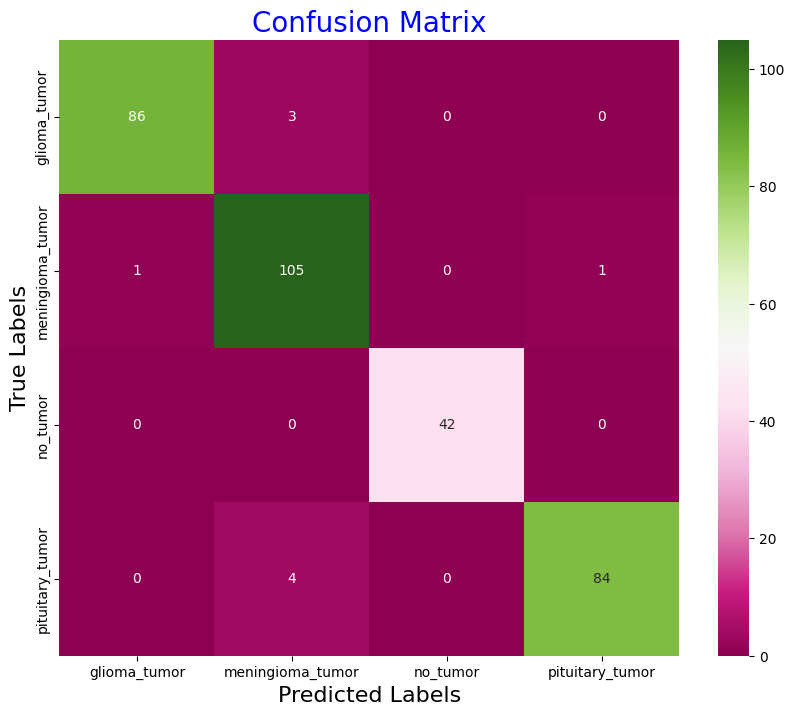

In [40]:
plot_confusion_matrix(y_true, y_pred, class_names)